## Data description
To decrease the bias and create a reliable authorship attribution dataset the following criteria
have been chosen to filter out authors in Gdelt database: English language writing authors,
authors that have enough books available (at least 5), 19th century authors. With these criteria
50 authors have been selected and their books were queried through Big Query Gdelt database.
The next task has been cleaning the dataset due to OCR reading problems in the original raw
form. To achieve that, firstly all books have been scanned through to get the overall number of
unique words and each words frequencies. While scanning the texts, the first 500 words and the
last 500 words have been removed to take out specific features such as the name of the author,
the name of the book and other word specific features that could make the classification task
easier. After this step, we have chosen top 10,000 words that occurred in the whole 50 authors
text data corpus. The words that are not in top 10,000 words were removed while keeping the
rest of the sentence structure intact. Afterwards, the words are represented with numbers from
1 to 10,000 reverse ordered according to their frequencies. The entire book is split into text
fragments with 1000 words each. We separately maintained author and book identification
number for each one of them in different arrays. Text segments with less than 1000 words were
filled with zeros to keep them in the dataset as well. 1000 words make approximately 2 pages of
writing, which is long enough to extract a variety of features from the document. The reason
why we have represented top 10,000 words with numbers is to keep the anonymity of texts and
allow researchers to run feature extraction techniques faster. Dealing with large amounts of text
data can be more challenging than numerical data for some feature extraction techniques. 

In [1]:
import os
import json
import re
from os.path import join
import pandas as pd
import numpy as np

from string import punctuation
from nltk.stem.snowball import RussianStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time

from sklearn.datasets import fetch_20newsgroups

%matplotlib inline


[nltk_data] Downloading package punkt to /home/norrilsk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/norrilsk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
tmp =['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles']
RND_SEED = int(time())
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, categories=tmp)

specSymb = {"«", "»", "—", "“", "-", "№"}
specSymb =  punctuation + "«»—“-№"
pattern = re.compile("[" + re.escape(specSymb) + "]")

stopEng = stopwords.words('english')

stemmer_eng = SnowballStemmer("english")


## Load data

In [14]:
data = twenty_train.data

print(twenty_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles']


In [15]:
def preprocess(text):
    text = text.lower()
    text = re.sub(pattern, '', text)
    tokens = word_tokenize(text)
    tokens_without_nums = filter(lambda x: not x.isdigit(), tokens)  # skip all numbers
    tokens_without_stop = filter(lambda x: x not in stopEng, tokens_without_nums)
    tokens_stem_eng = map(lambda x: stemmer_eng.stem(x), tokens_without_stop)
    
    return " ".join(tokens_stem_eng)

In [16]:
%%time
for i in range(len(data)):
    data[i] = preprocess(data[i])

CPU times: user 19.5 s, sys: 4 ms, total: 19.5 s
Wall time: 19.5 s


In [17]:
X = np.array(data)
y = twenty_train.target

In [18]:
print(y[:15])

[6 1 1 2 1 1 8 5 3 3 6 4 4 0 4]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state = RND_SEED)

In [22]:
X_train.shape[0], X_test.shape[0]

(4154, 1039)

## Define vectorizer and model

In [23]:
vect_count = CountVectorizer(binary=True)
vect_tfidf = TfidfVectorizer()
vect_hash = HashingVectorizer()


In [24]:
logreg = LogisticRegression(C=1, solver="liblinear")  
svm = SVC()

In [25]:
def plot_roc_auc(y_score, y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    f1 = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    figure(figsize=(len(classes), len(classes)), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
def fit_model(X_train, X_test, y_train, y_test, model, vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = metrics.precision_score(y_test, y_pred, average ="micro")
    recall = metrics.recall_score(y_test, y_pred, average ="micro")
    
    authors = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred, labels = authors)
    plot_confusion_matrix(cm, classes=authors, normalize=True,
                      title='Normalized confusion matrix')
    print("precision: %s;\nrecall %s" % (precision, recall))

    y_score = model.decision_function(X_test)

Normalized confusion matrix


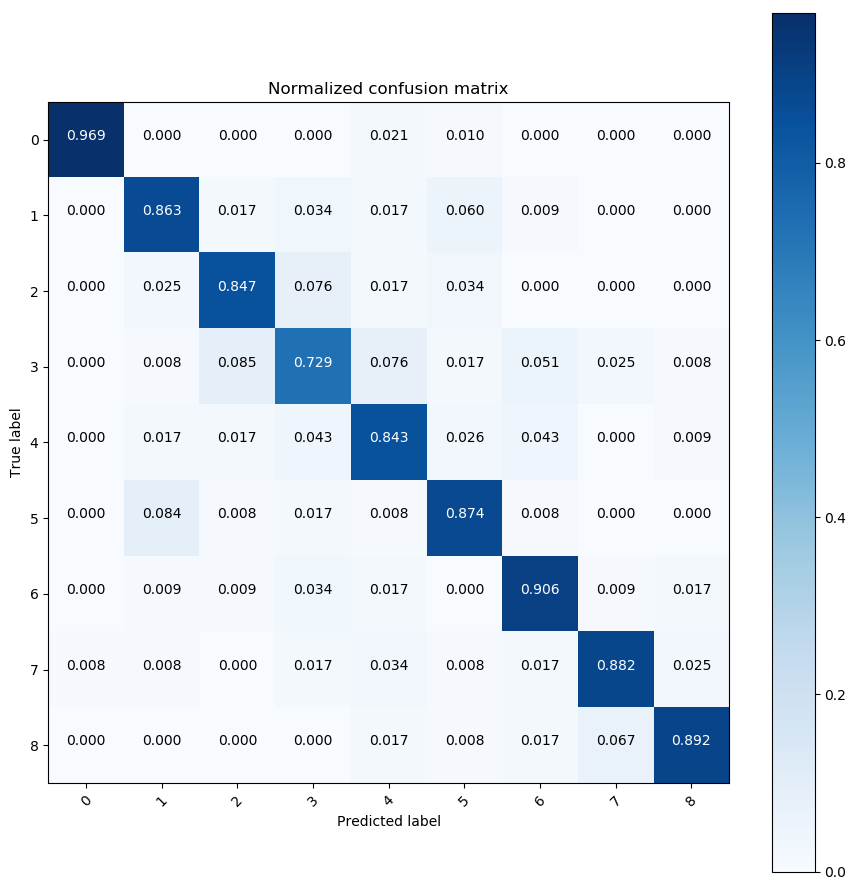

precision: 0.865255052935515;
recall 0.865255052935515
CPU times: user 6.74 s, sys: 584 ms, total: 7.32 s
Wall time: 4.57 s


In [33]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_count)

Normalized confusion matrix


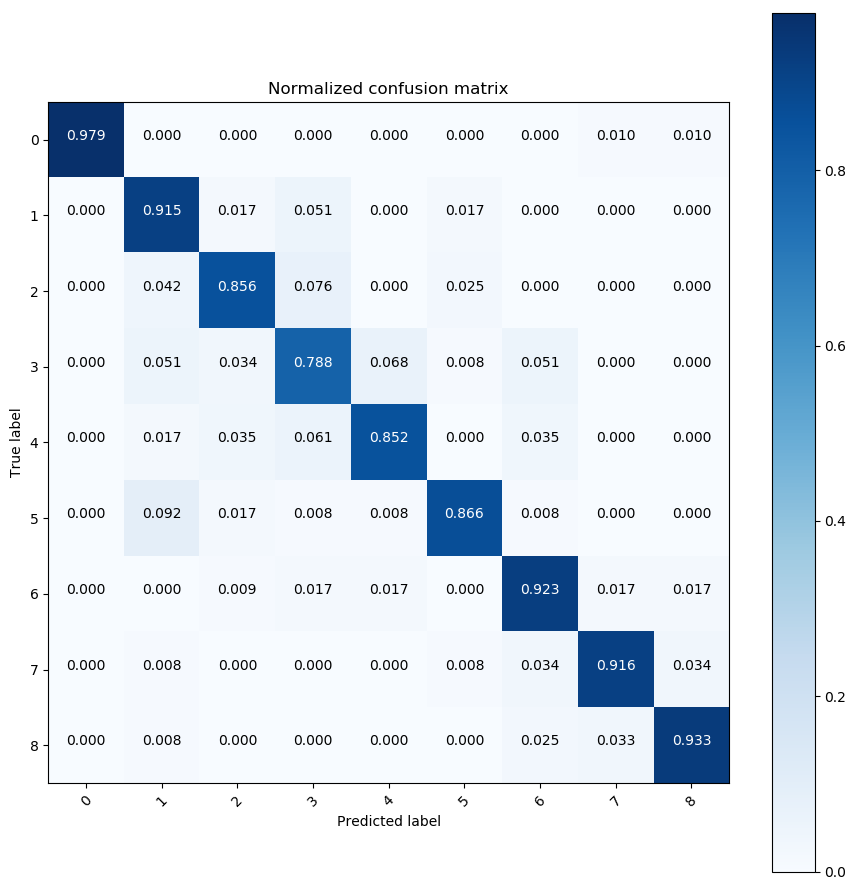

precision: 0.890279114533205;
recall 0.890279114533205
CPU times: user 4.3 s, sys: 560 ms, total: 4.86 s
Wall time: 3.15 s


In [48]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_tfidf)

Normalized confusion matrix


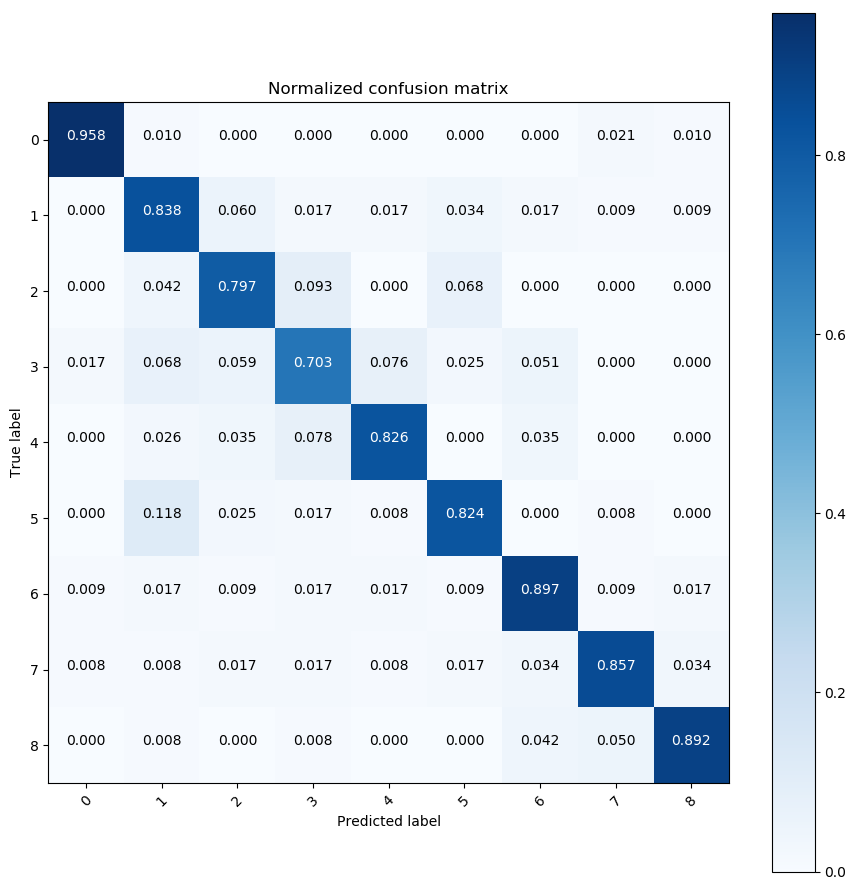

precision: 0.8411934552454283;
recall 0.8411934552454283
CPU times: user 14.8 s, sys: 792 ms, total: 15.6 s
Wall time: 8.67 s


In [49]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_hash)

## Learn with vowpal wabbit

In [34]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'


In [35]:
with open("." +'/20ng_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(X_train, y_train):
        vw_train_data.write(to_vw_format(text, target))
with open("." +'/20ng_test_mult.vw', 'w') as vw_test_data:
    for text in X_test:
        vw_test_data.write(to_vw_format(text))

In [42]:
t = len(tmp)
t

9

In [43]:
%%time

!vw --oaa 9 ./20ng_train_mult.vw \
-f ./20ng_model_mult.vw --loss_function=hinge

final_regressor = ./20ng_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ./20ng_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        3        1      115
1.000000 1.000000            2            2.0        7        3      140
0.750000 0.500000            4            4.0        8        7       56
0.625000 0.500000            8            8.0        5        8       54
0.687500 0.750000           16           16.0        2        5       96
0.781250 0.875000           32           32.0        1        2      105
0.718750 0.656250           64           64.0  unknown        2       38
0.632812 0.546875          128          128.0        4        4      115
0.554688 0.476562          256          256.0        7        7      361
0.470703 0.386719 

In [44]:
%%time
!vw -i ./20ng_model_mult.vw -t \
-d ./20ng_test_mult.vw \
-p ./20ng_test_predictions_mult.txt

only testing
predictions = ./20ng_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ./20ng_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown        1       54
1.000000 1.000000            2            2.0  unknown        8       56
1.000000 1.000000            4            4.0  unknown        2       53
1.000000 1.000000            8            8.0  unknown        6       51
1.000000 1.000000           16           16.0  unknown        1      102
1.000000 1.000000           32           32.0  unknown        3       74
1.000000 1.000000           64           64.0  unknown        7      143
1.000000 1.000000          128          128.0  unknown        7      276
1.000000 1.000000          256          256.0  unknown        6      13

In [45]:
with open('./20ng_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [46]:
accuracy_score(y_test, test_prediction_mult)

0.7844080846968239

In [47]:
print(classification_report(y_test, test_prediction_mult))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        96
          1       0.53      0.91      0.67       117
          2       0.82      0.81      0.82       118
          3       0.77      0.77      0.77       118
          4       0.84      0.83      0.84       115
          5       0.89      0.88      0.89       119
          6       0.80      0.87      0.84       117
          7       0.89      0.90      0.90       119
          8       0.89      0.93      0.91       120

avg / total       0.73      0.78      0.75      1039



/home/norrilsk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
